## 1. Import Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings
from pathlib import Path

# Text processing
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud

# Configuration
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# Download required NLTK data
nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)

print("✓ Libraries imported successfully")

✓ Libraries imported successfully


## 2. Load the Dataset

In [2]:
# Define paths
DATA_PATH = Path('../data/raw/sentiment140.csv')
PROCESSED_PATH = Path('../data/processed')
VISUALS_PATH = Path('../visuals')

# Create directories if they don't exist
PROCESSED_PATH.mkdir(parents=True, exist_ok=True)

# Load dataset
# Columns: target, ids, date, flag, user, text
column_names = ['target', 'ids', 'date', 'flag', 'user', 'text']
df = pd.read_csv(DATA_PATH, encoding='latin-1', names=column_names, header=None)

print(f"Dataset shape: {df.shape}")
print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
df.head()

Dataset shape: (1600000, 6)
Memory usage: 556.14 MB
Memory usage: 556.14 MB


,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


## 3. Initial Exploration

In [ ]:
# Dataset info
print("=" * 50)
print("DATASET INFORMATION")
print("=" * 50)
print(f"Shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")

# Check for missing values
print("\n" + "=" * 50)
print("MISSING VALUES")
print("=" * 50)
print(f"Total missing values: {df.isnull().sum().sum()}")

# Sentiment distribution (original: 0=negative, 4=positive)
print("\n" + "=" * 50)
print("SENTIMENT DISTRIBUTION")
print("=" * 50)
print(df['target'].value_counts())

# Convert target labels: 0 (negative) stays 0, 4 (positive) becomes 1
df['sentiment'] = df['target'].map({0: 0, 4: 1})
df['sentiment_label'] = df['sentiment'].map({0: 'negative', 1: 'positive'})
print("\nConverted labels (0=negative, 1=positive):")
print(df['sentiment'].value_counts())

DATASET INFORMATION
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   ids     1600000 non-null  int64 
 2   date    1600000 non-null  object
 3   flag    1600000 non-null  object
 4   user    1600000 non-null  object
 5   text    1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB

BASIC STATISTICS
             target           ids
count  1.600000e+06  1.600000e+06
mean   2.000000e+00  1.998818e+09
std    2.000001e+00  1.935761e+08
min    0.000000e+00  1.467810e+09
25%    0.000000e+00  1.956916e+09
50%    2.000000e+00  2.002102e+09
75%    4.000000e+00  2.177059e+09
max    4.000000e+00  2.329206e+09
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 

## 4. Visualize Sentiment Distribution

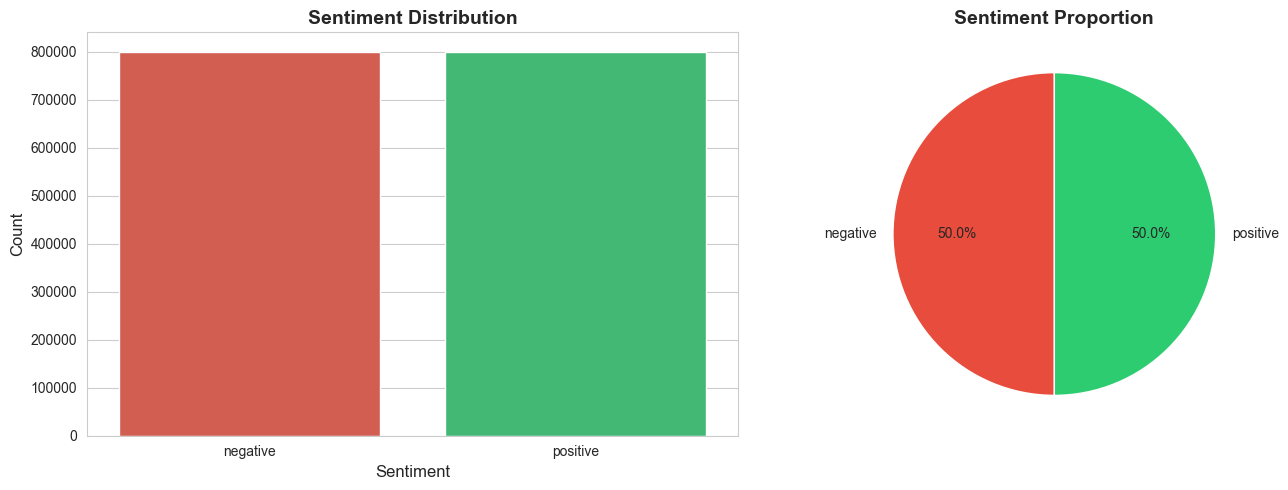

✓ Visualization saved to visuals/charts/sentiment_distribution.png


In [7]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Count plot
sns.countplot(data=df, x='sentiment_label', palette=['#e74c3c', '#2ecc71'], ax=axes[0])
axes[0].set_title('Sentiment Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Sentiment', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)

# Pie chart
df['sentiment_label'].value_counts().plot.pie(
    autopct='%1.1f%%',
    colors=['#e74c3c', '#2ecc71'],
    startangle=90,
    ax=axes[1]
)
axes[1].set_title('Sentiment Proportion', fontsize=14, fontweight='bold')
axes[1].set_ylabel('')

plt.tight_layout()
plt.savefig('../visuals/charts/sentiment_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Visualization saved to visuals/charts/sentiment_distribution.png")

## 5. Text Length Analysis

In [8]:
# Calculate text statistics
df['text_length'] = df['text'].str.len()
df['word_count'] = df['text'].str.split().str.len()

print("Text Statistics:")
print(df[['text_length', 'word_count']].describe())

Text Statistics:
        text_length    word_count
count  1.600000e+06  1.600000e+06
mean   7.409011e+01  1.317615e+01
std    3.644114e+01  6.957978e+00
min    6.000000e+00  1.000000e+00
25%    4.400000e+01  7.000000e+00
50%    6.900000e+01  1.200000e+01
75%    1.040000e+02  1.900000e+01
max    3.740000e+02  6.400000e+01


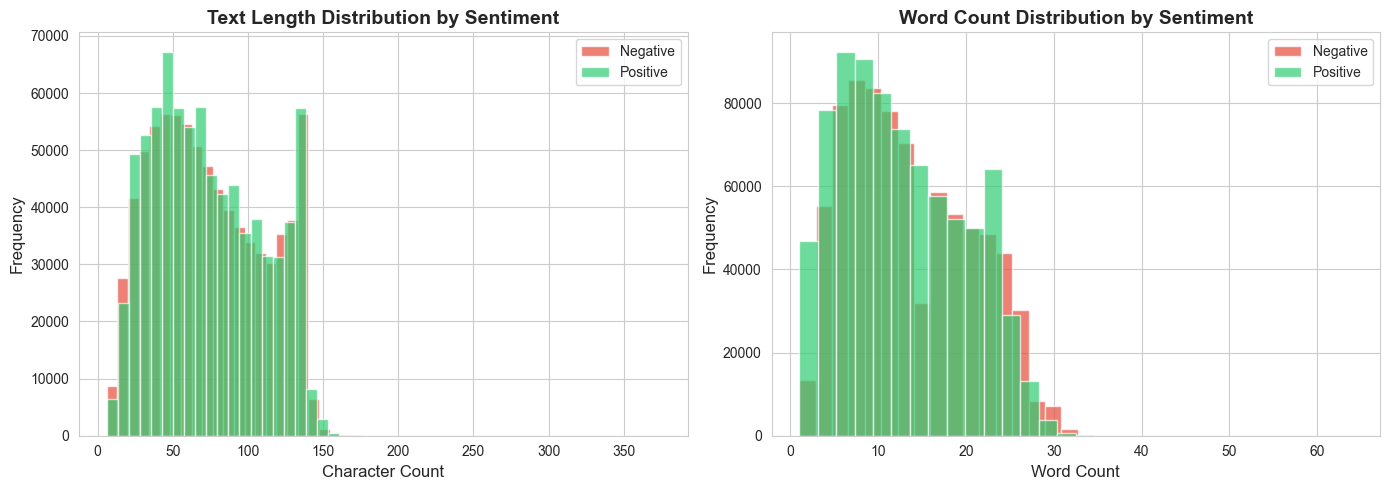

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Text length distribution by sentiment
df[df['sentiment'] == 0]['text_length'].hist(bins=50, alpha=0.7, label='Negative', color='#e74c3c', ax=axes[0])
df[df['sentiment'] == 1]['text_length'].hist(bins=50, alpha=0.7, label='Positive', color='#2ecc71', ax=axes[0])
axes[0].set_title('Text Length Distribution by Sentiment', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Character Count', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].legend()

# Word count distribution
df[df['sentiment'] == 0]['word_count'].hist(bins=30, alpha=0.7, label='Negative', color='#e74c3c', ax=axes[1])
df[df['sentiment'] == 1]['word_count'].hist(bins=30, alpha=0.7, label='Positive', color='#2ecc71', ax=axes[1])
axes[1].set_title('Word Count Distribution by Sentiment', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Word Count', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].legend()

plt.tight_layout()
plt.savefig('../visuals/charts/text_statistics.png', dpi=300, bbox_inches='tight')
plt.show()

## 6. Text Cleaning Functions

In [10]:
def clean_text(text):
    """
    Clean tweet text by removing URLs, mentions, hashtags, and special characters.
    """
    # Convert to lowercase
    text = text.lower()
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # Remove mentions and hashtags
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#\w+', '', text)
    
    # Remove special characters and numbers (keep only letters and spaces)
    text = re.sub(r'[^a-z\s]', ' ', text)
    
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

# Test the function
sample_text = "@user This is a #sample tweet with http://example.com URL and 123 numbers!"
print(f"Original: {sample_text}")
print(f"Cleaned: {clean_text(sample_text)}")

Original: @user This is a #sample tweet with http://example.com URL and 123 numbers!
Cleaned: this is a tweet with url and numbers


## 7. Apply Text Cleaning

In [11]:
# For faster processing, we'll work with a sample (use full dataset for final model)
# Adjust sample_size as needed (100000 for quick testing, None for full dataset)
sample_size = 100000  # Set to None to use full dataset

if sample_size:
    # Stratified sampling to maintain class balance
    df_sample = df.groupby('sentiment', group_keys=False).apply(
        lambda x: x.sample(n=sample_size//2, random_state=42)
    ).reset_index(drop=True)
    print(f"Using sample of {len(df_sample)} tweets")
else:
    df_sample = df.copy()
    print(f"Using full dataset of {len(df_sample)} tweets")

print("\nCleaning text... This may take a few minutes.")
df_sample['text_clean'] = df_sample['text'].apply(clean_text)

# Remove empty texts after cleaning
df_sample = df_sample[df_sample['text_clean'].str.len() > 0].reset_index(drop=True)

print(f"✓ Cleaned {len(df_sample)} tweets")
print(f"\nSample of cleaned texts:")
df_sample[['text', 'text_clean', 'sentiment_label']].head(10)

Using sample of 100000 tweets

Cleaning text... This may take a few minutes.
✓ Cleaned 99735 tweets

Sample of cleaned texts:
✓ Cleaned 99735 tweets

Sample of cleaned texts:


,text,text_clean,sentiment_label
0,@xnausikaax oh no! where did u order from? tha...,oh no where did u order from that s horrible,negative
1,A great hard training weekend is over. a coup...,a great hard training weekend is over a couple...,negative
2,"Right, off to work Only 5 hours to go until I...",right off to work only hours to go until i m f...,negative
3,I am craving for japanese food,i am craving for japanese food,negative
4,Jean Michel Jarre concert tomorrow gotta work...,jean michel jarre concert tomorrow gotta work ...,negative
5,@xPowxBangxBoomx dammiitt!! i wish i had MTV,dammiitt i wish i had mtv,negative
6,@Rohan_01 You know..it's really sad that u kno...,you know it s really sad that u know that ur c...,negative
7,@FaketragedyCom i know,i know,negative
8,@JudahGabriel i wish i had that much to say,i wish i had that much to say,negative
9,"ow, i can't move my neck or my back hurts to...",ow i can t move my neck or my back hurts too m...,negative


## 8. Generate Word Clouds

In [12]:
# Prepare text for word clouds
stop_words = set(stopwords.words('english'))

negative_text = ' '.join(df_sample[df_sample['sentiment'] == 0]['text_clean'])
positive_text = ' '.join(df_sample[df_sample['sentiment'] == 1]['text_clean'])

print(f"Negative text corpus: {len(negative_text)} characters")
print(f"Positive text corpus: {len(positive_text)} characters")

Negative text corpus: 3261692 characters
Positive text corpus: 3053872 characters


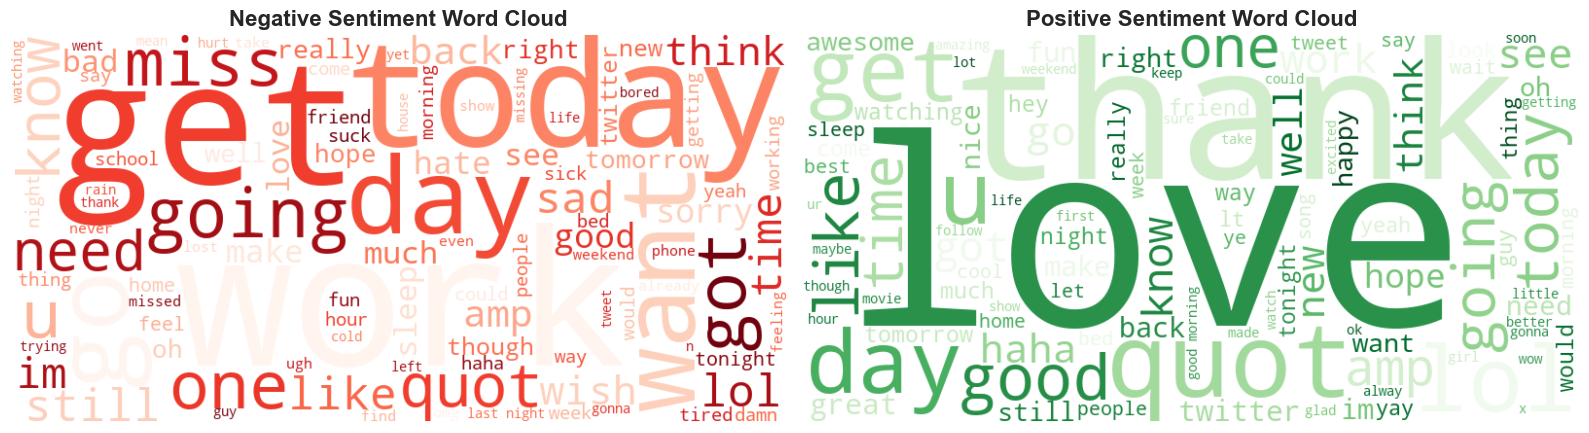

✓ Word clouds saved


In [13]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Negative word cloud
wordcloud_neg = WordCloud(
    width=800,
    height=400,
    background_color='white',
    stopwords=stop_words,
    colormap='Reds',
    max_words=100
).generate(negative_text)

axes[0].imshow(wordcloud_neg, interpolation='bilinear')
axes[0].set_title('Negative Sentiment Word Cloud', fontsize=16, fontweight='bold')
axes[0].axis('off')

# Positive word cloud
wordcloud_pos = WordCloud(
    width=800,
    height=400,
    background_color='white',
    stopwords=stop_words,
    colormap='Greens',
    max_words=100
).generate(positive_text)

axes[1].imshow(wordcloud_pos, interpolation='bilinear')
axes[1].set_title('Positive Sentiment Word Cloud', fontsize=16, fontweight='bold')
axes[1].axis('off')

plt.tight_layout()
plt.savefig('../visuals/wordclouds/sentiment_wordclouds.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Word clouds saved")

## 9. Most Common Words Analysis

In [ ]:
from collections import Counter

def get_top_words(text_series, n=20):
    """Get the most common words from a text series."""
    words = ' '.join(text_series).split()
    words = [w for w in words if w not in stop_words and len(w) > 2]
    return Counter(words).most_common(n)

# Get top words for each sentiment
top_negative = get_top_words(df_sample[df_sample['sentiment'] == 0]['text_clean'])
top_positive = get_top_words(df_sample[df_sample['sentiment'] == 1]['text_clean'])

print("Top 20 words in NEGATIVE tweets:")
for word, count in top_negative[:10]:
    print(f"  {word}: {count}")

print("\nTop 20 words in POSITIVE tweets:")
for word, count in top_positive[:10]:
    print(f"  {word}: {count}")

Top 20 words in NEGATIVE tweets:
  get: 2914
  work: 2908
  like: 2591
  day: 2574
  today: 2353
  got: 2071
  back: 2001
  going: 2001
  really: 1984
  miss: 1951
  good: 1947
  want: 1922
  still: 1766
  know: 1722
  sad: 1721
  time: 1716
  one: 1705
  quot: 1636
  home: 1526
  lol: 1518


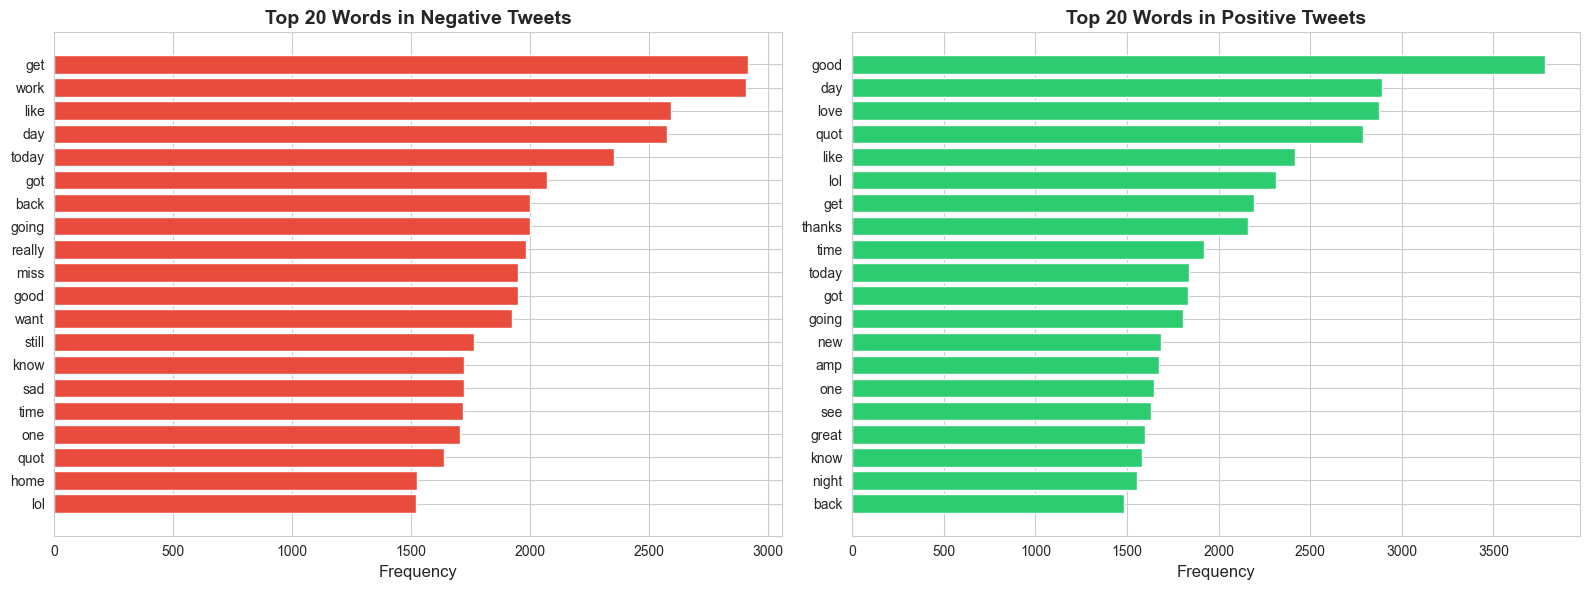

In [17]:
# Visualize top words
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Negative words
words_neg, counts_neg = zip(*top_negative)
axes[0].barh(words_neg, counts_neg, color='#e74c3c')
axes[0].set_title('Top 20 Words in Negative Tweets', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Frequency', fontsize=12)
axes[0].invert_yaxis()

# Positive words
words_pos, counts_pos = zip(*top_positive)
axes[1].barh(words_pos, counts_pos, color='#2ecc71')
axes[1].set_title('Top 20 Words in Positive Tweets', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Frequency', fontsize=12)
axes[1].invert_yaxis()

plt.tight_layout()
plt.savefig('../visuals/charts/top_words_by_sentiment.png', dpi=300, bbox_inches='tight')
plt.show()

## 10. Save Cleaned Data

In [18]:
# Select relevant columns for saving
df_clean = df_sample[['text', 'text_clean', 'sentiment', 'sentiment_label']].copy()

# Save to CSV
output_path = '../data/processed/cleaned_tweets.csv'
df_clean.to_csv(output_path, index=False)

print(f"✓ Cleaned dataset saved to: {output_path}")
print(f"  Shape: {df_clean.shape}")
print(f"  Size: {Path(output_path).stat().st_size / 1024**2:.2f} MB")

✓ Cleaned dataset saved to: ../data/processed/cleaned_tweets.csv
  Shape: (99735, 4)
  Size: 14.37 MB


## 11. Summary Statistics

In [19]:
print("="*60)
print("PREPROCESSING SUMMARY")
print("="*60)
print(f"Original dataset size: {len(df):,} tweets")
print(f"Processed dataset size: {len(df_clean):,} tweets")
print(f"\nSentiment distribution:")
print(df_clean['sentiment'].value_counts())
print(f"\nClass balance: {df_clean['sentiment'].value_counts(normalize=True) * 100}")
print(f"\nAverage text length (before): {df_sample['text_length'].mean():.1f} characters")
print(f"Average text length (after): {df_clean['text_clean'].str.len().mean():.1f} characters")
print(f"\nAverage word count: {df_clean['text_clean'].str.split().str.len().mean():.1f} words")
print("\n" + "="*60)
print("✓ Notebook 01 Complete!")
print("Next: Notebook 02 - Feature Engineering & ML Models")
print("="*60)

PREPROCESSING SUMMARY
Original dataset size: 1,600,000 tweets
Processed dataset size: 99,735 tweets

Sentiment distribution:
sentiment
0    49893
1    49842
Name: count, dtype: int64

Class balance: sentiment
0    50.025568
1    49.974432
Name: proportion, dtype: float64

Average text length (before): 74.2 characters
Average text length (after): 62.3 characters

Average word count: 13.0 words

✓ Notebook 01 Complete!
Next: Notebook 02 - Feature Engineering & ML Models

Average word count: 13.0 words

✓ Notebook 01 Complete!
Next: Notebook 02 - Feature Engineering & ML Models
